<a href="https://colab.research.google.com/github/SlokomManel/Blur-So-me/blob/master/LensKit_Python_PerBlur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

This notebook gets you started with a brief nDCG evaluation with LensKit for Python with a simple experiment with the MovieLens 100K data set.

## Setup

We first need to install LensKit:

In [ ]:
%pip install lenskit

Download the MovieLens data:

In [ ]:
# %%!
# wget -q -O ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip
# unzip -f ml-100k.zip

['Archive:  ml-100k.zip']

Now we can import LensKit utilities:

In [ ]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn
from lenskit.algorithms import item_knn, user_knn, als, tf
from lenskit.algorithms import basic

And Pandas is very useful:

In [ ]:
import pandas as pd

## Loading Data

We're going to use the ML-100K data set:

In [ ]:
# ml100k = ML100K('ml-100k')
# ratings = ml100k.ratings
# ratings.head()

names = ['user', 'item', 'rating', 'timestamp']
# train = pd.read_csv ("/content/TrainingSet_blurMe_ML1M_obfuscated_0.1_greedy_avg_top-1.dat", sep="::", names= names)
# train = pd.read_csv ("/content/TrainingSet_50_ML1M_blurmepp_obfuscated_greedy_0.05_2_strategic.dat", sep="::", names= names)
# train = pd.read_csv ("/content/TrainingSet_thresh50_blurSome_AverageML1M_obfuscated_Top50IndicativeItems_greedy_0.02_2.dat", sep="::", names= names)
# train = pd.read_csv ("/content/TrainingSet_thresh50_blurSome_AverageML1M_obfuscated_Top50IndicativeItems_greedy_0.02_2_strategic.dat", sep="::", names= names)
train = pd.read_csv ("/content/TrainingSet_FX_blurmepp_obfuscated_greedy_0.02_2_strategic.dat", sep="::", names= names)
# train = pd.read_csv ("/content/TrainingSet_FX_Thresh50_Top50_Predicted_blurSome_obfuscated_greedy_0.02_2_strategic.dat", sep="::", names= names)
# train = pd.read_csv ("/content/trainingSet_ml_1m_1.csv", sep=",", names= names)
test = pd.read_csv ("/content/testSet_FX_1.csv", sep=",", names= names)

names_user = ['user', 'gender', 'age'] #, 'occ', 'zip']
user_df = pd.read_csv ("/content/subset_FX_User_O.csv", sep= ",", names= names_user)
user_df
train
test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


,user,item,rating,timestamp
0,753,1186,2,0
1,74,2215,4,0
2,805,832,4,0
3,359,2802,4,0
4,1341,675,2,0
...,...,...,...,...
73807,1848,318,4,0
73808,1762,789,3,0
73809,1290,350,4,0
73810,2272,2735,3,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defining Algorithms

Let's set up two algorithms:

In [ ]:
# algo_ii = knn.ItemItem(20)
# algo_ii = knn.UserUser(20)
# algo_als = als.BiasedMF(50)
# BPR = tf.BPR(20)
# BPR1 = tf.BPR(50)
BPR2 = tf.BPR(100)

## Running the Evaluation

In LensKit, our evaluation proceeds in 2 steps:

1. Generate recommendations
2. Measure them

If memory is a concern, we can measure while generating, but we will not do that for now.

We will first define a function to generate recommendations from one algorithm over a single partition of the data set.  It will take an algorithm, a train set, and a test set, and return the recommendations.

**Note:** before fitting the algorithm, we clone it.  Some algorithms misbehave when fit multiple times.

**Note 2:** our algorithms do not necessarily implement the `Recommender` interface, so we adapt them. This fills in a default candidate selector.

The code function looks like this:

In [ ]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 10)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

Now, we will loop over the data and the algorithms, and generate recommendations:

In [ ]:
all_recs = []
test_data = []
# for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
test_data.append(test)
# all_recs.append(eval('BPR', BPR, train, test))
# all_recs.append(eval('BPR1', BPR1, train, test))
all_recs.append(eval('BPR2', BPR2, train, test))
# all_recs.append(eval('ALS', algo_als, train, test))

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


31/31 [==============================] - 1s 37ms/step - loss: 0.7025
Epoch 2/5
31/31 [==============================] - 1s 36ms/step - loss: 0.6991
Epoch 3/5
31/31 [==============================] - 1s 36ms/step - loss: 0.6931
Epoch 4/5
31/31 [==============================] - 1s 36ms/step - loss: 0.6730
Epoch 5/5
31/31 [==============================] - 1s 36ms/step - loss: 0.6168


With the results in place, we can concatenate them into a single data frame:

In [ ]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()


,item,score,user,rank,Algorithm
0,607,0.758140,753,1,BPR2
1,40,0.707021,753,2,BPR2
2,421,0.702212,753,3,BPR2
3,259,0.698067,753,4,BPR2
4,468,0.695110,753,5,BPR2


In [ ]:
all_recs_df = all_recs.copy ()
all_recs_df.to_csv ("FX_all_recs_BlurMore_GreedyRem.csv", index = False)


In [ ]:
all_recommendation = pd.merge (all_recs_df, user_df, on= 'user') 
all_recommendation_F = all_recommendation [all_recommendation ['gender']== 'F']
all_recommendation_M = all_recommendation [all_recommendation ['gender']== 'M']

To compute our analysis, we also need to concatenate the test data into a single frame:

In [ ]:
test_data = pd.concat(test_data, ignore_index=True)

In [ ]:
relevant_items = test_data.groupby('user')['item'].apply(list) 
relevant_items = relevant_items.to_frame()
relevant_items.columns = ["item_rel"]
relevant_items ["userid"] = relevant_items.index

relevant_items.columns

Index(['item_rel', 'userid'], dtype='object')

In [ ]:
recommended = all_recs_df.groupby ('user')['item'].apply (list)
recommended = recommended.to_frame()
recommended.columns = ["item_rec"]
recommended ["userid"] = recommended.index

recommended


,item_rec,userid
user,,
1,"[263, 607, 513, 723, 500, 238, 261, 468, 421, ...",1
2,"[744, 847, 607, 261, 23, 468, 780, 215, 790, 263]",2
3,"[821, 50, 780, 869, 386, 486, 378, 500, 259, 314]",3
4,"[238, 396, 37, 642, 700, 50, 790, 259, 20, 723]",4
5,"[215, 393, 238, 263, 35, 437, 700, 790, 723, 469]",5
...,...,...
2366,"[371, 365, 790, 396, 292, 700, 22, 271, 40, 468]",2366
2367,"[215, 513, 20, 50, 46, 263, 15, 17, 394, 197]",2367
2368,"[723, 292, 672, 642, 314, 700, 396, 365, 259, ...",2368


In [ ]:
both_data = pd.merge (relevant_items, recommended, on='userid')
both_data

,item_rel,userid,item_rec
0,"[53, 30, 11, 31, 57, 35, 20, 56, 36, 7]",1,"[263, 607, 513, 723, 500, 238, 261, 468, 421, ..."
1,"[73, 69, 66]",2,"[744, 847, 607, 261, 23, 468, 780, 215, 790, 263]"
2,"[150, 277, 216, 259, 187, 236, 96, 274, 132, 2...",3,"[821, 50, 780, 869, 386, 486, 378, 500, 259, 314]"
3,"[404, 18, 356, 388, 493, 454, 328, 300, 403, 3...",4,"[238, 396, 37, 642, 700, 50, 790, 259, 20, 723]"
4,"[426, 309, 514, 21, 512, 523, 509, 160, 526, 1...",5,"[215, 393, 238, 263, 35, 437, 700, 790, 723, 469]"
...,...,...,...
2344,"[114, 1476, 468, 281, 823, 1398, 1055, 760, 21...",2366,"[371, 365, 790, 396, 292, 700, 22, 271, 40, 468]"
2345,"[869, 711, 969, 822]",2367,"[215, 513, 20, 50, 46, 263, 15, 17, 394, 197]"
2346,"[346, 837, 817, 1047, 323, 469, 902, 970, 56, ...",2368,"[723, 292, 672, 642, 314, 700, 396, 365, 259, ..."
2347,"[633, 349, 397, 2, 15, 565]",2369,"[13, 393, 46, 292, 780, 723, 607, 421, 261, 31]"


In [ ]:
both_data['intersection'] = [len(set(a).intersection(b)) for a, b in zip(both_data.item_rel, both_data.item_rec)]
both_data.columns = ['item_rel', 'user', 'item_rec', 'intersection']
both_data= pd.merge (both_data, user_df, on= 'user')
both_data

,item_rel,user,item_rec,intersection,gender,age
0,"[53, 30, 11, 31, 57, 35, 20, 56, 36, 7]",1,"[263, 607, 513, 723, 500, 238, 261, 468, 421, ...",0,F,0
1,"[73, 69, 66]",2,"[744, 847, 607, 261, 23, 468, 780, 215, 790, 263]",0,M,0
2,"[150, 277, 216, 259, 187, 236, 96, 274, 132, 2...",3,"[821, 50, 780, 869, 386, 486, 378, 500, 259, 314]",1,M,0
3,"[404, 18, 356, 388, 493, 454, 328, 300, 403, 3...",4,"[238, 396, 37, 642, 700, 50, 790, 259, 20, 723]",3,M,0
4,"[426, 309, 514, 21, 512, 523, 509, 160, 526, 1...",5,"[215, 393, 238, 263, 35, 437, 700, 790, 723, 469]",0,F,0
...,...,...,...,...,...,...
2344,"[114, 1476, 468, 281, 823, 1398, 1055, 760, 21...",2366,"[371, 365, 790, 396, 292, 700, 22, 271, 40, 468]",6,M,0
2345,"[869, 711, 969, 822]",2367,"[215, 513, 20, 50, 46, 263, 15, 17, 394, 197]",0,F,0
2346,"[346, 837, 817, 1047, 323, 469, 902, 970, 56, ...",2368,"[723, 292, 672, 642, 314, 700, 396, 365, 259, ...",1,F,0
2347,"[633, 349, 397, 2, 15, 565]",2369,"[13, 393, 46, 292, 780, 723, 607, 421, 261, 31]",0,F,0


In [ ]:
sum_hits = both_data['intersection'].sum()
hr = sum_hits / len (test_data)
print (hr)

0.04588684766704601


In [ ]:
test_data_merge = pd.merge (test_data, user_df, on="user")
test_data_merge

,user,item,rating,timestamp,gender,age
0,753,1186,2,0,F,0
1,753,418,3,0,F,0
2,753,280,3,0,F,0
3,753,658,2,0,F,0
4,753,2024,2,0,F,0
...,...,...,...,...,...,...
73807,1599,384,4,0,F,0
73808,1135,394,2,0,M,0
73809,154,834,5,0,F,0
73810,1513,433,2,0,F,0


In [ ]:
test_data_F = test_data_merge [test_data_merge ['gender']== 'F']
test_data_M = test_data_merge [test_data_merge ['gender']== 'M']


In [ ]:
"""
# ML1M
l_m = [589.0,1233.0,2706.0,1090.0,2959.0,1250.0,2427.0,2490.0,1208.0,1266.0,3654.0,1748.0,1262.0,1396.0,1374.0,2700.0,1265.0,1089.0,1222.0,231.0,2770.0,1676.0,2890.0,1228.0,1136.0,3360.0,3298.0,1663.0,3811.0,2011.0,1261.0,233.0,3361.0,2366.0,1127.0,1276.0,3555.0,1214.0,3929.0,299.0,1304.0,3468.0,1095.0,150.0,1213.0,750.0,3082.0,6.0,111.0,3745.0,349.0,541.0,2791.0,785.0,1060.0,1294.0,1302.0,2012.0,1256.0,1292.0,2948.0,3683.0,3030.0,3836.0,913.0,2150.0,32.0,2826.0,2721.0,590.0,3623.0,2997.0,3868.0,2944.0,3147.0,1610.0,3508.0,2046.0,21.0,1249.0,10.0,1283.0,3760.0,2712.0,3617.0,3421.0,3552.0,3256.0,1079.0,3053.0,1517.0,3196.0,2662.0,1953.0,2670.0,3578.0,2371.0,3334.0,2028.0,2502.0,2951.0,2278.0,364.0,3462.0,924.0,2401.0,3163.0,2311.0,852.0,2916.0,1378.0,3384.0,1046.0,524.0,70.0,370.0,3035.0,3513.0,2917.0,3697.0,24.0,1957.0,3494.0,1912.0,3752.0,2013.0,3452.0,3928.0,2987.0,431.0,2759.0,1387.0,1882.0,1274.0,3327.0,3638.0,1288.0,2867.0,2728.0,2921.0,2433.0,161.0,3386.0,517.0,741.0,1287.0,1231.0,3062.0,2288.0,3753.0,529.0,3793.0,3052.0,2447.0,1320.0,3819.0,1303.0,922.0,3022.0,260.0,2640.0,858.0,493.0,3006.0,480.0,2410.0,333.0,1178.0,3814.0,2702.0,1203.0,2922.0,2761.0,1625.0,3366.0,223.0,3213.0,996.0,2188.0,2628.0,3358.0,2648.0,3788.0,953.0,999.0,3754.0,3910.0,3016.0,3863.0,303.0,3263.0,1080.0,786.0,3764.0,2105.0,3543.0,3018.0,2607.0,3681.0,592.0,145.0,2303.0,1682.0,553.0,1019.0,1272.0,3646.0,1544.0,235.0,908.0,3615.0,2792.0,3354.0,1204.0,2167.0,2455.0,1587.0,3629.0,1227.0,2901.0,2687.0,1883.0,104.0,1210.0,1201.0,3169.0,3098.0,3688.0,2409.0,3198.0,610.0,1923.0,1982.0,2501.0,165.0,2403.0,784.0,2871.0,2889.0,628.0,2300.0,417.0,3671.0,3100.0,1221.0,3914.0,1218.0,3608.0,3152.0,3429.0,3265.0,1794.0,952.0,1391.0,2518.0,410.0,3535.0,2333.0,1713.0,1263.0,3947.0,2605.0,707.0,2973.0,2795.0,1965.0,373.0,2970.0,3916.0,556.0,3703.0,95.0,466.0,2060.0,3066.0,3177.0,368.0,2088.0,1476.0,163.0,3422.0,58.0,1244.0,1689.0,2002.0,1929.0,599.0,1711.0,2259.0,1209.0,3524.0,1977.0,1371.0,3506.0,3104.0,3444.0,1693.0,965.0,1732.0,2600.0,3424.0,3755.0,2450.0,3826.0,2301.0,3801.0,3927.0,1298.0,198.0,2118.0,112.0,2478.0,471.0,1673.0,1246.0,2734.0,2529.0,2806.0,2094.0,1948.0,3710.0,2093.0,45.0,648.0,3504.0,2968.0,1722.0,1963.0,2840.0,1747.0,2476.0,1348.0,2411.0,3871.0,3175.0,2360.0,1092.0,3190.0,3729.0,1405.0,1007.0,2034.0,492.0,367.0,3248.0,3806.0,537.0,3619.0,1702.0,3210.0,1734.0,2644.0,2252.0,1597.0,1200.0,1401.0,1416.0,107.0,383.0,1379.0,2764.0,2116.0,1036.0,60.0,2682.0,2115.0,1317.0,1876.0,3394.0,1254.0,2243.0,2606.0,3925.0,1503.0,3869.0,1612.0,390.0,328.0,3903.0,3375.0,2422.0,3087.0,1627.0,3770.0,273.0,3430.0,3678.0,3576.0,2377.0,3113.0,196.0,3036.0,3525.0,1584.0,799.0,2236.0,3267.0,954.0,2412.0,1690.0,1879.0,30.0,1205.0,1252.0,2470.0,2686.0,3397.0,2367.0,2015.0,3804.0,3002.0,1377.0,3740.0,1594.0,1978.0,2456.0,3821.0,2038.0,891.0,1342.0,2669.0,3628.0,1966.0,2808.0,3324.0,366.0,3634.0,3794.0,3509.0,1063.0,2467.0,3420.0,324.0,3773.0,1927.0,1241.0,2231.0,3742.0,1960.0,1390.0,1542.0,2672.0,83.0,1376.0,3174.0,2395.0,1248.0,3362.0,2029.0,225.0,2362.0,2491.0,110.0,3527.0,1267.0,3203.0,511.0,1025.0,2769.0,3792.0,3785.0,1973.0,1952.0,326.0,2541.0,3593.0,3698.0,2058.0,2459.0,1375.0,3273.0,1278.0,154.0,1179.0,2009.0,1976.0,300.0,735.0,504.0,2423.0,1365.0,2676.0,3300.0,3701.0,2793.0,2915.0,963.0,3505.0,2178.0,1920.0,3934.0,813.0,3357.0,2580.0,2430.0,1975.0,1695.0,2542.0,1701.0,2195.0,2560.0,1215.0,637.0,3252.0,440.0,100.0,540.0,3091.0,2654.0,1885.0,2372.0,2384.0,1979.0,3507.0,1414.0,1251.0,1187.0,3316.0,1609.0,2841.0,2149.0,1986.0,2624.0,1305.0,2287.0,1858.0,2004.0,1260.0,1687.0,1785.0,1257.0,516.0,3725.0,1358.0,2253.0,3918.0,157.0,2374.0,2976.0,1100.0,1866.0,3802.0,2140.0,1646.0,737.0,2092.0,2165.0,1604.0,2772.0,2249.0,3500.0,193.0,3037.0,665.0,1196.0,3728.0,194.0,555.0,1431.0,3851.0,3564.0,2322.0,1370.0,3379.0,3099.0,3188.0,321.0,2863.0,2492.0,13.0,3840.0,2378.0,1255.0,3271.0,3946.0,1550.0,1017.0,3086.0,3189.0,1445.0,3074.0,3908.0,3000.0,1837.0,2296.0,340.0,2306.0,1238.0,3551.0,1389.0,3689.0,1884.0,800.0,3693.0,2526.0,2327.0,3180.0,387.0,1193.0,3254.0,3614.0,2829.0,459.0,448.0,3033.0,1779.0,458.0,3477.0,1388.0,1289.0,748.0,3289.0,1024.0,1411.0,2458.0,3569.0,2836.0,3948.0,1057.0,2877.0,2633.0,3078.0,2289.0,514.0,3831.0,3733.0,3311.0,535.0,361.0,290.0,2027.0,1408.0,1198.0,948.0,1356.0,2522.0,1859.0,2321.0,2356.0,2660.0,3017.0,1245.0,1985.0,1395.0,1340.0,1103.0,2781.0,3812.0,2861.0,544.0,1974.0,474.0,3276.0,2497.0,2323.0,3304.0,1980.0,2851.0,3682.0,1981.0,1633.0,2620.0,3068.0,1129.0,304.0,2457.0,2530.0,1931.0,125.0,548.0,2148.0,3487.0,2651.0,1735.0,2896.0,3632.0,89.0,680.0,2113.0,3519.0,1008.0,2387.0,2912.0,325.0,3159.0,171.0,3355.0,892.0,2593.0,990.0,3669.0,1051.0,1301.0,1983.0,711.0,2828.0,2924.0,523.0,3368.0,2521.0,3148.0,296.0,2488.0,1867.0,1382.0,3917.0,2626.0,2883.0,522.0,3846.0,2882.0,1639.0,3015.0,3639.0,2212.0,1665.0,3834.0,1297.0,829.0,15.0,2083.0,534.0,2942.0,2898.0,1247.0,3008.0,2663.0,861.0,1180.0,2817.0,155.0,3266.0,3039.0,2107.0,419.0,761.0,3469.0,3544.0,2210.0,1970.0,3338.0,3307.0,1161.0,3048.0,1054.0,432.0,2796.0,2425.0,3879.0,2117.0,3747.0,3930.0,685.0,2525.0,742.0,1128.0,204.0,3709.0,3417.0,2656.0,3937.0,1844.0,1237.0,2885.0,3073.0,888.0,2181.0,1091.0,3214.0,3880.0,1273.0,315.0,3809.0,436.0,3115.0,3387.0,2111.0,3694.0,468.0,2775.0,1752.0,3301.0,2810.0,2347.0,1696.0,2837.0,1341.0,2023.0,1591.0,565.0,3769.0,2961.0,518.0,788.0,2134.0,3120.0,3771.0,1581.0,246.0,3767.0,1130.0,44.0,63.0,527.0,893.0,3626.0,2843.0,3590.0,456.0,3817.0,487.0,1726.0,2645.0,810.0,860.0,1058.0,3529.0,3094.0,2907.0,2334.0,2344.0,2641.0,3230.0,2271.0,1016.0,151.0,377.0,1494.0,2402.0,450.0,3538.0,3717.0,2694.0,2745.0,2389.0,3780.0,3141.0,3865.0,281.0,2472.0,3441.0,3272.0,3734.0,2255.0,850.0,1750.0,2507.0,2272.0,2991.0,3021.0,3498.0,2983.0,3766.0,1810.0,1437.0,2024.0,842.0,1184.0,2725.0,1488.0,2064.0,2731.0,1999.0,2139.0,2965.0,1078.0,409.0,3692.0,3758.0,1924.0,2019.0,1596.0,137.0,760.0,2971.0,569.0,897.0,305.0,1083.0,2238.0,2701.0,1753.0,3364.0,3643.0,3351.0,2404.0,2597.0,1459.0,2835.0,3680.0,1945.0,2567.0,673.0,3568.0,3516.0,3830.0,2726.0,2515.0,611.0,947.0,121.0,568.0,1176.0,1998.0,1640.0,1626.0,3032.0,1601.0,835.0,1739.0,2755.0,388.0,484.0,1279.0,1326.0,172.0,2787.0,2977.0,3596.0,2939.0,1855.0,3306.0,3372.0,1865.0,1725.0,3241.0,1432.0,3089.0,2179.0,870.0,2671.0,944.0,2325.0,968.0,2535.0,2041.0,2802.0,2723.0,882.0,3695.0,2985.0,3658.0,2471.0,3365.0,1516.0,1113.0,667.0,378.0,2981.0,3415.0,3401.0,764.0,2897.0,297.0,3810.0,210.0,2773.0,1787.0,3901.0,268.0,3339.0,3402.0,2647.0,3221.0,1450.0,416.0,719.0,3385.0,3183.0,528.0,2169.0,1834.0,3490.0,1733.0,3069.0,178.0,1135.0,2929.0,2460.0,2751.0,2780.0,998.0,2475.0,20.0,292.0,3919.0,255.0,505.0,811.0,88.0,3920.0,3347.0,547.0,1527.0,3622.0,479.0,2121.0,2852.0,3952.0,424.0,1219.0,1869.0,413.0,393.0,567.0,2866.0,2264.0,2055.0,214.0,3898.0,3803.0,3737.0,921.0,3034.0,2294.0,3935.0,1366.0,1154.0,3412.0,3395.0,322.0,354.0,3659.0,2675.0,1997.0,849.0,2017.0,2615.0,1322.0,118.0,2025.0,2986.0,3873.0,1889.0,442.0,1793.0,496.0,3476.0,259.0,1399.0,3807.0,3233.0,831.0,1992.0,2061.0,2536.0,3822.0,3416.0,2652.0,2086.0,2283.0,3520.0,694.0,1890.0,2822.0,1458.0,2068.0,681.0,180.0,3690.0,2673.0,2482.0,3933.0,2040.0,423.0,885.0,1330.0,116.0,3572.0,1329.0,762.0,3146.0,159.0,2076.0,1677.0,3239.0,2462.0,3700.0,2842.0,1783.0,2634.0,3759.0,2979.0,1860.0,2328.0,3326.0,3432.0,3319.0,1655.0,1760.0,2437.0,632.0,3893.0,275.0,2594.0,16.0,2164.0,1351.0,1153.0,2244.0,1942.0,2171.0,3774.0,2815.0,3818.0,3392.0,2073.0,101.0,557.0,3178.0,3491.0,1120.0,2753.0,1281.0,2665.0,1589.0,1468.0,274.0,936.0,3585.0,1901.0,1635.0,1535.0,394.0,330.0,1880.0,2566.0,2326.0,2119.0,2591.0,2596.0,3765.0,1406.0,3168.0,443.0,2215.0,202.0,1085.0,2627.0,3143.0,3603.0,747.0,3106.0,2520.0,3095.0,1670.0,3031.0,2196.0,2905.0,1551.0,1439.0,3503.0,3448.0,793.0,2914.0,1971.0,437.0,1910.0,1230.0,3129.0,3636.0,2993.0,2189.0,3847.0,3942.0,3820.0,3799.0,1355.0,2809.0,1780.0,3125.0,2839.0,3784.0,287.0,3149.0,3845.0,2003.0,2609.0,3789.0,2275.0,731.0,1623.0,3262.0,1746.0,566.0,1532.0,2408.0,355.0,841.0,1044.0,3670.0,3537.0,181.0,3648.0,3726.0,1170.0,3691.0,2350.0,464.0,12.0,3816.0,2376.0,3602.0,3309.0,623.0,2407.0,2137.0,1946.0,1574.0,3939.0,1420.0,2390.0,2707.0,1519.0,1543.0,1504.0,1190.0,1851.0,1771.0,2473.0,2902.0,2537.0,3275.0,2441.0,2748.0,3727.0,2544.0,1918.0,122.0,2847.0,1533.0,2098.0,1474.0,3425.0,3020.0,486.0,3201.0,3768.0,780.0,3909.0,1632.0,1791.0,3473.0,3139.0,710.0,725.0,1583.0,1853.0,3367.0,2512.0,76.0,1160.0,3673.0,1826.0,2943.0,2082.0,1886.0,749.0,2571.0,2830.0,1472.0,3157.0,2170.0,293.0,3938.0,3154.0,1895.0,2256.0,2187.0,2112.0,2237.0,3407.0,1846.0,513.0,716.0,3731.0,3875.0,3409.0,840.0,2286.0,1692.0,2913.0,925.0,1529.0,1703.0,2351.0,177.0,1606.0,1772.0,3587.0,1680.0,663.0,503.0,1325.0,2528.0,828.0,263.0,3884.0,2610.0,2483.0,2201.0,3012.0,564.0,2295.0,743.0,704.0,3633.0,2153.0,3049.0,3322.0,434.0,2418.0,607.0,1915.0,2737.0,2618.0,626.0,2192.0,3718.0,1404.0,3610.0,1490.0,66.0,2391.0,1497.0,209.0,336.0,941.0,1684.0,1741.0,3.0,3651.0,1253.0,2994.0,3532.0,3775.0,720.0,2383.0,1955.0,967.0,3652.0,970.0,433.0,2960.0,1715.0,1493.0,674.0,3713.0,937.0,463.0,1531.0,2349.0,851.0,572.0,126.0,3310.0,744.0,1415.0,2332.0,2175.0,1599.0,563.0,585.0,3514.0,703.0,3140.0,2353.0,2480.0,3744.0,158.0,2740.0,9.0,3349.0,3676.0,3398.0,3075.0,3025.0,1743.0,1598.0,1385.0,162.0,485.0,1454.0,2200.0,881.0,59.0,2335.0,765.0,3777.0,1284.0,2894.0,2089.0,133.0,3123.0,1148.0,2659.0,1003.0,2666.0,1147.0,3047.0,536.0,2523.0,3427.0,1053.0,989.0,2183.0,2499.0,2767.0,3661.0,2818.0,430.0,2400.0,1037.0,2804.0,1731.0,1142.0,2419.0,3118.0,2234.0,1482.0,1679.0,2209.0,2868.0,3313.0,1068.0,987.0,702.0,1006.0,854.0,1704.0,2393.0,1412.0,3523.0,3228.0,755.0,3294.0,2250.0,2211.0,2045.0,2945.0,2246.0,1369.0,1144.0,1567.0,2268.0,3076.0,426.0,2869.0,3890.0,2589.0,2554.0,384.0,3640.0,630.0,679.0,2524.0,460.0,2302.0,1984.0,3536.0,2988.0,1617.0,1138.0,1038.0,445.0,2911.0,71.0,1457.0,561.0,365.0,2207.0,1539.0,1335.0,3374.0,1603.0,617.0,734.0,3135.0,2001.0,2689.0,3121.0,53.0,81.0,3511.0,2824.0,796.0,1891.0,2936.0,3431.0,3142.0,2668.0,3110.0,3331.0,1928.0,815.0,1652.0,103.0,3167.0,2754.0,3842.0,2935.0,3280.0,2510.0,1436.0,78.0,2819.0,1728.0,1871.0,2705.0,1842.0,3470.0,526.0,3940.0,1461.0,3776.0,1650.0,241.0,863.0,2744.0,889.0,510.0,533.0,3531.0,759.0,175.0,1149.0,439.0,2834.0,980.0,1194.0,3832.0,729.0,3762.0,2545.0,3380.0,2232.0,3295.0,478.0,2095.0,56.0,886.0,3860.0,3749.0,2667.0,3573.0,2317.0,2538.0,2557.0,2887.0,992.0,1040.0,1830.0,766.0,1718.0,3127.0,2646.0,1861.0,2102.0,818.0,3116.0,3042.0,1425.0,228.0,188.0,2341.0,3371.0,1426.0,3465.0,643.0,3320.0,909.0,3563.0,1903.0,3867.0,570.0,878.0,1282.0,184.0,3732.0,728.0,331.0,2185.0,3092.0,1475.0,3187.0,313.0,3521.0,2813.0,3410.0,2451.0,14.0,3601.0,3208.0,1972.0,3400.0,1744.0,1350.0,3783.0,3282.0,3756.0,1334.0,1361.0,1291.0,2638.0,874.0,664.0,1164.0,2318.0,551.0,2416.0,2904.0,1925.0,2760.0,3013.0,3575.0,2858.0,2221.0,2602.0,2223.0,2999.0,2265.0,847.0,2878.0,2394.0,2623.0,1098.0,1121.0,1849.0,1538.0,598.0,3346.0,3588.0,3342.0,809.0,3800.0,3627.0,3905.0,3850.0,2509.0,2032.0,1528.0,573.0,3182.0,244.0,3096.0,2071.0,19.0,1168.0,1664.0,3235.0,1839.0,2658.0,310.0,2016.0,227.0,867.0,2166.0,1887.0,3056.0,1647.0,1062.0,1817.0,3344.0,33.0,696.0,3216.0,2611.0,1864.0,2204.0,1502.0,3433.0,545.0,3735.0,1433.0,3205.0,3434.0,1234.0,2486.0,3442.0,682.0,2290.0,3736.0,2415.0,1004.0,1071.0,454.0,2632.0,2582.0,3381.0,1534.0,3779.0,3751.0,1681.0,1825.0,3889.0,3389.0,782.0,3837.0,3084.0,3900.0,2397.0,1553.0,2691.0,757.0,666.0,3184.0,2239.0,3318.0,2708.0,3647.0,1907.0,3292.0,3482.0,190.0,3172.0,96.0,791.0,961.0,3876.0,75.0,633.0,1991.0,1455.0,3533.0,130.0,2534.0,401.0,2794.0,758.0,2129.0,684.0,690.0,2735.0,3778.0,3377.0,2452.0,3207.0,1471.0,288.0,2176.0,1675.0,2124.0,1770.0,2310.0,3333.0,2674.0,23.0,3891.0,3548.0,1039.0,2821.0,1466.0,3404.0,672.0,977.0,3054.0,488.0,3212.0,3314.0,789.0,3743.0,958.0,2825.0,1969.0,981.0,385.0,1878.0,642.0,1102.0,1510.0,792.0,2776.0,1124.0,1125.0,2811.0,2033.0,2736.0,1795.0,3305.0,1590.0,823.0,706.0,3443.0,2191.0,2138.0,884.0,820.0,3687.0,2730.0,655.0,578.0,2865.0,3242.0,2533.0,1872.0,2292.0,3464.0,3772.0,3522.0,2716.0,2343.0,120.0,1816.0,3337.0,2932.0,1649.0,3463.0,2649.0,1189.0,428.0,312.0,614.0,827.0,2955.0,580.0,718.0,67.0,3283.0,1119.0,3485.0,1558.0,508.0,3653.0,601.0,1764.0,1908.0,2584.0,3026.0,582.0,1315.0,657.0,660.0,3437.0,3158.0,2281.0,1134.0,2135.0,2163.0,3040.0,3458.0,3243.0,3887.0,2242.0,467.0,138.0,530.0,584.0,701.0,3229.0,2758.0,2563.0,2749.0,402.0,574.0,1152.0,895.0,3782.0,1548.0,3070.0,1799.0,3359.0,1339.0,311.0,3151.0,123.0,1055.0,1224.0,1989.0,2996.0,2539.0,3085.0,1123.0,1470.0,1619.0,2578.0,658.0,2463.0,344.0,453.0,1905.0,1101.0,77.0,3236.0,515.0,576.0,2152.0,3297.0,3440.0,1714.0,2428.0,1520.0,183.0,2713.0,3574.0,1486.0,826.0,763.0,1070.0,2214.0,579.0,644.0,651.0,859.0,1118.0,1145.0,1630.0,1852.0,2235.0,2277.0,2484.0,2742.0,3220.0,3321.0,962.0,3403.0,2131.0,3597.0,1873.0,3941.0,3317.0,2308.0,1364.0,2895.0,3828.0,991.0,226.0,2879.0,200.0,1392.0,730.0,771.0,3888.0,3488.0,1165.0,2592.0,1651.0,3644.0,1877.0,2474.0,3666.0,3057.0,3277.0,2556.0,1820.0,2850.0,3001.0,790.0,3130.0,2420.0,717.0,774.0,1511.0,2812.0,142.0,1115.0,1386.0,3312.0,3621.0,3373.0,3237.0,93.0,1133.0,2386.0,2583.0,649.0,258.0,3065.0,1440.0,2636.0,1773.0,1863.0,1360.0,3904.0,2254.0,3797.0,3291.0,2519.0,3722.0,993.0,1293.0,2218.0,1613.0,132.0,1724.0,868.0,3336.0,583.0,865.0,638.0,316.0,1430.0,1993.0,732.0,843.0,975.0,2213.0,2217.0,3202.0,3376.0,2880.0,3378.0,2771.0,814.0,1217.0,521.0,3460.0,853.0,3945.0,3899.0,1419.0,135.0,2579.0,472.0,213.0,167.0,2527.0,2240.0,374.0,3486.0,250.0,2493.0,3419.0,451.0,2906.0,964.0,2552.0,2313.0,1809.0,1526.0,3253.0,1258.0,2984.0,2364.0,1310.0,2893.0,1343.0,2661.0,1212.0,3611.0,1935.0,2643.0,2947.0,2982.0,714.0,3637.0,1501.0,836.0,229.0,2941.0,3439.0,147.0,80.0,3258.0,896.0,745.0,3674.0,2159.0,923.0,1270.0,2461.0,2729.0,2637.0,1464.0,2798.0,353.0,1332.0,1707.0,1240.0,502.0,2859.0,3600.0,2108.0,973.0,1359.0]
l_m = l_m [:10]
l_f = [920.0,3844.0,2369.0,1088.0,3534.0,1207.0,17.0,1041.0,3512.0,3418.0,1188.0,902.0,2336.0,3911.0,1441.0,141.0,2690.0,265.0,928.0,39.0,2762.0,906.0,838.0,2657.0,2125.0,3565.0,1967.0,2291.0,914.0,932.0,1620.0,2160.0,247.0,222.0,261.0,2881.0,2145.0,3072.0,1028.0,1956.0,2080.0,1286.0,3798.0,1959.0,28.0,2248.0,3247.0,3594.0,3155.0,1345.0,531.0,1277.0,593.0,3044.0,3083.0,3005.0,1296.0,1380.0,2020.0,105.0,1678.0,1608.0,2572.0,3791.0,1104.0,2144.0,318.0,1186.0,1073.0,595.0,2724.0,1641.0,351.0,2908.0,357.0,3079.0,1688.0,3556.0,3186.0,2406.0,224.0,1962.0,1480.0,3251.0,11.0,345.0,3526.0,1784.0,951.0,3668.0,2485.0,1958.0,2739.0,916.0,950.0,2443.0,3684.0,236.0,904.0,898.0,587.0,552.0,339.0,2143.0,3481.0,3097.0,3067.0,1449.0,47.0,36.0,616.0,3281.0,1259.0,661.0,2348.0,562.0,3606.0,2496.0,2085.0,1271.0,372.0,2857.0,3325.0,1394.0,1081.0,1032.0,918.0,1409.0,314.0,899.0,733.0,2245.0,381.0,2316.0,232.0,2405.0,2677.0,1066.0,2396.0,2282.0,1059.0,2622.0,1941.0,959.0,3479.0,3124.0,1197.0,1777.0,915.0,955.0,1648.0,3705.0,3061.0,22.0,34.0,926.0,1285.0,1.0,2875.0,1150.0,3545.0,2664.0,2155.0,1097.0,262.0,3915.0,971.0,2581.0,2186.0,3702.0,3105.0,2280.0,3604.0,3515.0,1513.0,2331.0,1500.0,2803.0,945.0,2639.0,3051.0,837.0,3408.0,457.0,1801.0,2506.0,4.0,2469.0,270.0,46.0,1235.0,2355.0,2346.0,1357.0,461.0,3255.0,3176.0,3350.0,2975.0,2014.0,3936.0,2072.0,1353.0,2006.0,1397.0,2612.0,1099.0,1367.0,3270.0,938.0,2357.0,94.0,412.0,1518.0,3591.0,538.0,2000.0,2846.0,708.0,329.0,2995.0,653.0,1280.0,5.0,337.0,588.0,2546.0,1022.0,2692.0,2468.0,1569.0,905.0,1031.0,900.0,2565.0,1541.0,2926.0,2312.0,3730.0,1900.0,2718.0,1021.0,597.0,3185.0,2746.0,327.0,2805.0,3101.0,2920.0,289.0,3269.0,1674.0,477.0,3686.0,2077.0,2801.0,581.0,2133.0,3257.0,3724.0,3296.0,3554.0,3478.0,1479.0,3720.0,491.0,1014.0,1236.0,3134.0,695.0,1645.0,2763.0,1013.0,1096.0,1856.0,2827.0,248.0,1875.0,3211.0,3672.0,215.0,3224.0,3396.0,469.0,1897.0,3528.0,2870.0,917.0,930.0,1654.0,1009.0,3328.0,3786.0,1307.0,907.0,3870.0,1422.0,2206.0,2114.0,2324.0,2575.0,919.0,3467.0,1047.0,1806.0,350.0,230.0,2505.0,48.0,182.0,1537.0,144.0,170.0,2141.0,1916.0,3081.0,1191.0,1086.0,2598.0,805.0,546.0,3179.0,1407.0,153.0,2635.0,2057.0,2037.0,1327.0,3436.0,3145.0,446.0,2193.0,3341.0,942.0,1337.0,1913.0,195.0,2132.0,1804.0,3562.0,3706.0,1172.0,1042.0,2946.0,317.0,2514.0,3112.0,1093.0,1035.0,3499.0,1616.0,3011.0,2151.0,1111.0,1545.0,613.0,1043.0,2774.0,2154.0,2621.0,52.0,3060.0,2617.0,3723.0,206.0,3133.0,1821.0,1964.0,2504.0,211.0,2454.0,532.0,218.0,3156.0,43.0,1586.0,1126.0,2096.0,455.0,927.0,2007.0,778.0,2097.0,3117.0,539.0,691.0,943.0,1947.0,3567.0,1223.0,2194.0,2081.0,1268.0,1300.0,2747.0,1892.0,830.0,1914.0,1573.0,3302.0,671.0,3471.0,3825.0,3111.0,1064.0,1299.0,252.0,3004.0,2091.0,931.0,2337.0,605.0,1183.0,61.0,1020.0,3763.0,1727.0,74.0,3599.0,3708.0,465.0,29.0,3741.0,3457.0,2399.0,781.0,69.0,3635.0,3808.0,650.0,3249.0,2732.0,1621.0,1686.0,3435.0,3857.0,3299.0,3426.0,1225.0,2247.0,176.0,343.0,2972.0,2853.0,1033.0,272.0,2788.0,1393.0,2918.0,2432.0,3285.0,203.0,1465.0,801.0,1917.0,2431.0,342.0,3714.0,2967.0,3553.0,79.0,3951.0,1683.0,3071.0,3102.0,302.0,497.0,3655.0,2261.0,237.0,3260.0,3877.0,2174.0,2266.0,3716.0,3699.0,2782.0,1769.0,266.0,1173.0,2693.0,3093.0,1029.0,253.0,1658.0,277.0,279.0,848.0,839.0,2365.0,2738.0,1264.0,271.0,1643.0,1269.0,2043.0,3855.0,1030.0,1346.0,2104.0,2052.0,2161.0,2142.0,2719.0,2574.0,2053.0,1410.0,3912.0,1381.0,3660.0,2446.0,2613.0,2314.0,1132.0,978.0,1498.0,348.0,2168.0,3466.0,669.0,3649.0,2448.0,2899.0,1611.0,2940.0,362.0,8.0,1463.0,26.0,3557.0,1994.0,1758.0,414.0,1027.0,2681.0,3088.0,3483.0,140.0,3835.0,3391.0,1936.0,2205.0,2123.0,3861.0,332.0,3450.0,2585.0,2050.0,3618.0,425.0,709.0,1605.0,276.0,3827.0,846.0,2267.0,2359.0,2952.0,2786.0,3923.0,1939.0,1290.0,3240.0,3388.0,1547.0,338.0,3712.0,722.0,3063.0,242.0,715.0,3679.0,3571.0,3286.0,668.0,1069.0,2276.0,1438.0,2511.0,2688.0,1657.0,2900.0,3161.0,168.0,3539.0,199.0,2888.0,1624.0,3675.0,2436.0,647.0,724.0,82.0,542.0,1362.0,2424.0,117.0,2208.0,2109.0,3246.0,3019.0,3605.0,1904.0,360.0,267.0,2966.0,3620.0,700.0,3122.0,482.0,2741.0,334.0,2100.0,500.0,2173.0,1615.0,358.0,280.0,3932.0,369.0,3547.0,3739.0,3132.0,3849.0,1592.0,1788.0,875.0,2106.0,3719.0,3107.0,1423.0,3546.0,3839.0,1417.0,3566.0,3795.0,670.0,933.0,1177.0,520.0,2146.0,152.0,208.0,1175.0,3449.0,3274.0,27.0,3872.0,2733.0,207.0,2969.0,2927.0,957.0,2442.0,113.0,2078.0,2923.0,2084.0,1585.0,877.0,1807.0,1848.0,3882.0,3790.0,3926.0,2820.0,1629.0,3922.0,1571.0,3046.0,832.0,3896.0,2101.0,1600.0,3510.0,1087.0,294.0,2548.0,2453.0,386.0,2799.0,239.0,191.0,1717.0,1509.0,2099.0,911.0,1015.0,2590.0,85.0,3077.0,3264.0,3340.0,940.0,3114.0,146.0,1729.0,2498.0,309.0,1034.0,3484.0,2421.0,3438.0,2599.0,1827.0,1076.0,405.0,3461.0,3579.0,3813.0,1642.0,187.0,3238.0,3399.0,2005.0,3921.0,912.0,1840.0,2876.0,319.0,40.0,257.0,3287.0,880.0,844.0,754.0,1951.0,1874.0,1888.0,2241.0,2553.0,2203.0,1699.0,2297.0,550.0,2279.0,2886.0,3883.0,1549.0,2338.0,1922.0,452.0,3612.0,3144.0,1894.0,2026.0,2464.0,1049.0,2385.0,1824.0,2750.0,1185.0,2779.0,3902.0,2481.0,3580.0,2.0,2435.0,73.0,2956.0,3045.0,1012.0,1275.0,783.0,1473.0,2305.0,2049.0,512.0,2074.0,160.0,2720.0,1919.0,1814.0,3570.0,2531.0,375.0,3838.0,3549.0,2903.0,2778.0,507.0,1896.0,3451.0,2263.0,3199.0,3192.0,1671.0,2320.0,1515.0,438.0,363.0,341.0,3492.0,376.0,1562.0,2031.0,1295.0,1588.0,408.0,3405.0,1131.0,197.0,3894.0,307.0,1199.0,3268.0,447.0,186.0,808.0,2569.0,1961.0,1428.0,2540.0,1893.0,3284.0,1926.0,2873.0,2062.0,3624.0,1169.0,2513.0,3944.0,3128.0,575.0,1333.0,31.0,3595.0,3038.0,380.0,2696.0,3497.0,2342.0,2070.0,2130.0,1721.0,756.0,1932.0,1906.0,3662.0,935.0,3897.0,615.0,50.0,1105.0,956.0,1940.0,301.0,3330.0,2354.0,3406.0,84.0,99.0,3852.0,490.0,415.0,1797.0,1660.0,1811.0,1854.0,506.0,3625.0,406.0,3704.0,1094.0,2816.0,1163.0,2678.0,2122.0,1192.0,779.0,1836.0,2126.0,481.0,87.0,3577.0,2990.0,35.0,2629.0,3200.0,441.0,49.0,2864.0,1554.0,2784.0,3109.0,1499.0,346.0,577.0,1653.0,2202.0,3711.0,2616.0,1767.0,256.0,1117.0,1656.0,283.0,3584.0,2417.0,3721.0,2284.0,2978.0,3244.0,2042.0,397.0,2862.0,3454.0,1487.0,1582.0,2573.0,1018.0,1564.0,2568.0,2549.0,2844.0,1000.0,2054.0,2345.0,705.0,1669.0,1373.0,2048.0,429.0,3613.0,3663.0,1911.0,164.0,3924.0,949.0,420.0,3823.0,2570.0,359.0,92.0,2964.0,2434.0,179.0,217.0,1447.0,1719.0,2361.0,1943.0,148.0,1507.0,41.0,3895.0,1996.0,495.0,3949.0,2653.0,3103.0,2381.0,606.0,427.0,1413.0,379.0,3370.0,2379.0,1563.0,602.0,2711.0,2330.0,3447.0,3677.0,2293.0,2136.0,2642.0,1899.0,525.0,1050.0,2931.0,3138.0,3853.0,3363.0,3641.0,972.0,2962.0,3329.0,2358.0,169.0,2413.0,974.0,560.0,3206.0,3259.0,872.0,1995.0,1835.0,1496.0,3150.0,3805.0,2679.0,128.0,3518.0,2856.0,2925.0,483.0,543.0,462.0,2449.0,391.0,2586.0,2010.0,3393.0,1602.0,1755.0,3029.0,2494.0,2757.0,803.0,298.0,2500.0,1934.0,988.0,473.0,864.0,3007.0,2532.0,3261.0,2625.0,554.0,1631.0,2388.0,57.0,1167.0,2156.0,282.0,3456.0,249.0,382.0,2398.0,238.0,1798.0,1011.0,3217.0,1242.0,2953.0,2414.0,2550.0,1902.0,1084.0,2307.0,2128.0,131.0,2743.0,3055.0,1010.0,3290.0,1832.0,489.0,2630.0,3171.0,1949.0,245.0,3586.0,269.0,1954.0,2352.0,3343.0,2110.0,1579.0,129.0,3181.0,37.0,2021.0,2872.0,1344.0,3685.0,2257.0,2329.0,619.0,1354.0,1398.0,1312.0,659.0,2269.0,3428.0,804.0,2479.0,134.0,635.0,3866.0,2892.0,3950.0,2765.0,1444.0,422.0,2035.0,910.0,806.0,939.0,509.0,3859.0,1841.0,3738.0,173.0,1456.0,1756.0,1363.0,3041.0,3003.0,1427.0,3943.0,751.0,3445.0,986.0,2555.0,2614.0,997.0,192.0,3014.0,1561.0,1453.0,3874.0,136.0,2848.0,2722.0,2930.0,2992.0,3696.0,2103.0,3864.0,3707.0,776.0,1171.0,1384.0,558.0,1331.0,3501.0,639.0,2127.0,969.0,2559.0,3848.0,1139.0,166.0,1938.0,2823.0,2849.0,3664.0,1829.0,1107.0,2466.0,356.0,1812.0,1082.0,3194.0,185.0,1909.0,1349.0,2558.0,54.0,1316.0,2503.0,2426.0,2717.0,2309.0,3204.0,114.0,3881.0,2051.0,2219.0,476.0,2561.0,869.0,3843.0,934.0,2704.0,1709.0,149.0,1762.0,3667.0,371.0,2090.0,609.0,1112.0,291.0,3058.0,1831.0,2227.0,627.0,3197.0,499.0,2315.0,879.0,2439.0,621.0,389.0,3222.0,2768.0,3108.0,2517.0,3540.0,72.0,65.0,1477.0,3126.0,3215.0,594.0,1987.0,3423.0,1114.0,3833.0,1421.0,3502.0,1372.0,449.0,1822.0,2998.0,631.0,2874.0,2833.0,2974.0,3787.0,1672.0,2577.0,834.0,2047.0,2299.0,38.0,2180.0,807.0,3043.0,3665.0,1002.0,976.0,308.0,929.0,603.0,903.0,2304.0,3616.0,220.0,571.0,688.0,444.0,1056.0,3642.0,3390.0,1933.0,662.0,3136.0,960.0,1460.0,2587.0,2340.0,2797.0,3495.0,254.0,519.0,1232.0,2197.0,1211.0,767.0,3288.0,2697.0,596.0,3352.0,3892.0,984.0,2650.0,3446.0,320.0,435.0,769.0,3345.0,470.0,2884.0,787.0,1116.0,1730.0,612.0,3245.0,2516.0,2022.0,1446.0,411.0,1661.0,1546.0,278.0,3250.0,1523.0,2258.0,2934.0,1570.0,102.0,862.0,64.0,2445.0,746.0,798.0,1644.0,2854.0,2950.0,3550.0,2655.0,2562.0,2298.0,985.0,2067.0,640.0,2056.0,2147.0,982.0,887.0,1575.0,396.0,55.0,1614.0,212.0,3162.0,2079.0,42.0,2158.0,7.0,1685.0,559.0,1026.0,1572.0,3906.0,2608.0,1202.0,1442.0,2044.0,3824.0,3475.0,1556.0,1580.0,1720.0,1220.0,2727.0,1850.0,3027.0,2373.0,687.0,3010.0,833.0,1759.0,501.0,1659.0,124.0,1216.0,3293.0,1508.0,1815.0,1429.0,2800.0,2855.0,1857.0,139.0,2177.0,2063.0,3746.0,392.0,3542.0,189.0,2226.0,3913.0,156.0,18.0,475.0,2891.0,3854.0,1328.0,1754.0,3493.0,2683.0,2066.0,3028.0,2487.0,2162.0,2285.0,1881.0,3209.0,2949.0,2937.0,3119.0,2008.0,3862.0,3090.0,966.0,1593.0,1311.0,802.0,2831.0,1383.0,1870.0,2551.0,634.0,2440.0,407.0,2631.0,586.0,3480.0,1944.0,2989.0,3657.0,3858.0,1525.0,2695.0,2182.0,901.0,1489.0,1921.0,2785.0,1352.0,946.0,1862.0,97.0,1226.0,656.0,3581.0,1622.0,3885.0,2756.0,1988.0,1565.0,201.0,1162.0,3166.0,2260.0,2380.0,2339.0,1555.0,1950.0,1151.0,994.0,3137.0,3353.0,1306.0,3796.0,3489.0,2576.0,1990.0,2685.0,3160.0,3024.0,68.0,2777.0,3886.0,1323.0,2928.0,1023.0,3931.0,2190.0,398.0,2619.0,1061.0,1067.0,2919.0,3631.0,698.0,3459.0,2495.0,2444.0,3609.0,3232.0,775.0,3164.0,2370.0,2392.0,3645.0,821.0,753.0,1313.0,652.0,3761.0,108.0,3413.0,3592.0,306.0,2963.0,86.0,1484.0,1666.0,2429.0,3496.0,3474.0,3335.0,3878.0,1181.0,1514.0,352.0,1667.0,2363.0,98.0,2172.0,1174.0,692.0,3472.0,3315.0,1662.0,2184.0,1324.0,2036.0,295.0,3308.0,1206.0,697.0,1898.0,1077.0,1636.0,2039.0,3218.0,2233.0,1805.0,2715.0,3165.0,3453.0,641.0,205.0,2783.0,106.0,2714.0,2375.0,3173.0,216.0,3223.0,876.0,2382.0,1495.0,174.0,251.0,1694.0,736.0,119.0,3748.0,3131.0,1321.0,3517.0,1483.0,618.0,264.0,608.0,1005.0,1485.0,1347.0,498.0,3219.0,2766.0,1243.0,2789.0,2807.0,2069.0,25.0,347.0,90.0,2699.0,2251.0,1796.0,3757.0,3303.0,335.0,1792.0,1522.0,3414.0,3559.0,2814.0,2065.0,1937.0,2709.0,2860.0,2368.0,1833.0,1336.0,3598.0,549.0,2059.0,2465.0,1668.0,600.0,3715.0,2933.0,678.0,1845.0,2752.0,2075.0,1595.0,494.0,240.0,2790.0,645.0,3781.0,2018.0,1930.0,421.0,726.0,2273.0,62.0,1968.0,2120.0,2710.0,824.0,2477.0,866.0,712.0,1552.0,3841.0,219.0,418.0,1782.0,3050.0,2262.0,234.0,1566.0,2157.0,1749.0,2938.0,3064.0,243.0,3225.0,2087.0,3153.0,3907.0,3856.0,3829.0,3815.0,3750.0,3656.0,3650.0,3630.0,3607.0,3589.0,3583.0,3582.0,3561.0,3560.0,3558.0,3541.0,3530.0,3455.0,3411.0,3383.0,3382.0,3369.0,3356.0,3348.0,3332.0,3323.0,3279.0,3278.0,3234.0,3231.0,3227.0,3226.0,3195.0,3193.0,3191.0,3170.0,3080.0,3059.0,3023.0,3009.0,2980.0,2958.0,2957.0,2954.0,2910.0,2909.0,2845.0,2838.0,2832.0,2703.0,2698.0,2684.0,2680.0,2604.0,2603.0,2601.0,2595.0,2588.0,2564.0,2547.0,2543.0,2508.0,2489.0,2438.0,2319.0,2274.0,2270.0,2230.0,2229.0,2228.0,2225.0,2224.0,2222.0,2220.0,2216.0,2199.0,2198.0,2030.0,1868.0,1847.0,1843.0,1838.0,1828.0,1823.0,1819.0,1818.0,1813.0,1808.0,1803.0,1802.0,1800.0,1790.0,1789.0,1786.0,1781.0,1778.0,1776.0,1775.0,1774.0,1768.0,1766.0,1765.0,1763.0,1761.0,1757.0,1751.0,1745.0,1742.0,1740.0,1738.0,1737.0,1736.0,1723.0,1716.0,1712.0,1710.0,1708.0,1706.0,1705.0,1700.0,1698.0,1697.0,1691.0,1638.0,1637.0,1634.0,1628.0,1618.0,1607.0,1578.0,1577.0,1576.0,1568.0,1560.0,1559.0,1557.0,1540.0,1536.0,1530.0,1524.0,1521.0,1512.0,1506.0,1505.0,1492.0,1491.0,1481.0,1478.0,1469.0,1467.0,1462.0,1452.0,1451.0,1448.0,1443.0,1435.0,1434.0,1424.0,1418.0,1403.0,1402.0,1400.0,1368.0,1338.0,1319.0,1318.0,1314.0,1309.0,1308.0,1239.0,1229.0,1195.0,1182.0,1166.0,1159.0,1158.0,1157.0,1156.0,1155.0,1146.0,1143.0,1141.0,1140.0,1137.0,1122.0,1110.0,1109.0,1108.0,1106.0,1075.0,1074.0,1072.0,1065.0,1052.0,1048.0,1045.0,1001.0,995.0,983.0,979.0,894.0,890.0,883.0,873.0,871.0,857.0,856.0,855.0,845.0,825.0,822.0,819.0,817.0,816.0,812.0,797.0,795.0,794.0,777.0,773.0,772.0,770.0,768.0,752.0,740.0,739.0,738.0,727.0,723.0,721.0,713.0,699.0,693.0,689.0,686.0,683.0,677.0,676.0,675.0,654.0,646.0,636.0,629.0,625.0,624.0,622.0,620.0,604.0,591.0,404.0,403.0,400.0,399.0,395.0,323.0,286.0,285.0,284.0,221.0,143.0,127.0,115.0,109.0,91.0,51.0,1359.0,973.0,2108.0,3600.0,2859.0,502.0,1240.0,1707.0,1332.0,353.0,2798.0,1464.0,2637.0,2729.0,2461.0,1270.0,923.0,2159.0,3674.0,745.0,896.0,3258.0,80.0,147.0,3439.0,2941.0,229.0,836.0,1501.0,3637.0,714.0,2982.0,2947.0,2643.0,1935.0,3611.0,1212.0,2661.0,1343.0,2893.0,1310.0,2364.0,2984.0,1258.0,3253.0,1526.0,1809.0,2313.0,2552.0,964.0,2906.0,451.0,3419.0,2493.0,250.0,3486.0,374.0,2240.0,2527.0,167.0,213.0,472.0,2579.0,135.0,1419.0,3899.0,3945.0,853.0,3460.0,521.0,1217.0,814.0,2771.0,3378.0,2880.0,3376.0,3202.0,2217.0,2213.0,975.0,843.0,732.0,1993.0,1430.0,316.0,638.0,865.0,583.0,3336.0,868.0,1724.0,132.0,1613.0,2218.0,1293.0,993.0,3722.0,2519.0,3291.0,3797.0,2254.0,3904.0,1360.0,1863.0,1773.0,2636.0,1440.0,3065.0,258.0,649.0,2583.0,2386.0,1133.0,93.0,3237.0,3373.0,3621.0,3312.0,1386.0,1115.0,142.0,2812.0,1511.0,774.0,717.0,2420.0,3130.0,790.0,3001.0,2850.0,1820.0,2556.0,3277.0,3057.0,3666.0,2474.0,1877.0,3644.0,1651.0,2592.0,1165.0,3488.0,3888.0,771.0,730.0,1392.0,200.0,2879.0,226.0,991.0,3828.0,2895.0,1364.0,2308.0,3317.0,3941.0,1873.0,3597.0,2131.0,3403.0,962.0,3321.0,3220.0,2742.0,2484.0,2277.0,2235.0,1852.0,1630.0,1145.0,1118.0,859.0,651.0,644.0,579.0,2214.0,1070.0,763.0,826.0,1486.0,3574.0,2713.0,183.0,1520.0,2428.0,1714.0,3440.0,3297.0,2152.0,576.0,515.0,3236.0,77.0,1101.0,1905.0,453.0,344.0,2463.0,658.0,2578.0,1619.0,1470.0,1123.0,3085.0,2539.0,2996.0,1989.0,1224.0,1055.0,123.0,3151.0,311.0,1339.0,3359.0,1799.0,3070.0,1548.0,3782.0,895.0,1152.0,574.0,402.0,2749.0,2563.0,2758.0,3229.0,701.0,584.0,530.0,138.0,467.0,2242.0,3887.0,3243.0,3458.0,3040.0,2163.0,2135.0,1134.0,2281.0,3158.0,3437.0,660.0,657.0,1315.0,582.0,3026.0,2584.0,1908.0,1764.0,601.0,3653.0,508.0,1558.0,3485.0,1119.0,3283.0,67.0,718.0,580.0,2955.0,827.0,614.0,312.0,428.0,1189.0,2649.0,3463.0,1649.0,2932.0,3337.0,1816.0,120.0,2343.0,2716.0,3522.0,3772.0,3464.0,2292.0,1872.0,2533.0,3242.0,2865.0,578.0,655.0,2730.0,3687.0,820.0,884.0,2138.0,2191.0,3443.0,706.0,823.0,1590.0,3305.0,1795.0,2736.0,2033.0,2811.0,1125.0,1124.0,2776.0,792.0,1510.0,1102.0,642.0,1878.0,385.0,981.0,1969.0,2825.0,958.0,3743.0,789.0,3314.0,3212.0,488.0,3054.0,977.0,672.0,3404.0,1466.0,2821.0,1039.0,3548.0,3891.0,23.0,2674.0,3333.0,2310.0,1770.0,2124.0,1675.0,2176.0,288.0,1471.0,3207.0,2452.0,3377.0,3778.0,2735.0,690.0,684.0,2129.0,758.0,2794.0,401.0,2534.0,130.0,3533.0,1455.0,1991.0,633.0,75.0,3876.0,961.0,791.0,96.0,3172.0,190.0,3482.0,3292.0,1907.0,3647.0,2708.0,3318.0,2239.0,3184.0,666.0,757.0,2691.0,1553.0,2397.0,3900.0,3084.0,3837.0,782.0,3389.0,3889.0,1825.0,1681.0,3751.0,3779.0,1534.0,3381.0,2582.0,2632.0,454.0,1071.0,1004.0,2415.0,3736.0,2290.0,682.0,3442.0,2486.0,1234.0,3434.0,3205.0,1433.0,3735.0,545.0,3433.0,1502.0,2204.0,1864.0,2611.0,3216.0,696.0,33.0,3344.0,1817.0,1062.0,1647.0,3056.0,1887.0,2166.0,867.0,227.0,2016.0,310.0,2658.0,1839.0,3235.0,1664.0,1168.0,19.0,2071.0,3096.0,244.0,3182.0,573.0,1528.0,2032.0,2509.0,3850.0,3905.0,3627.0,3800.0,809.0,3342.0,3588.0,3346.0,598.0,1538.0,1849.0,1121.0,1098.0,2623.0,2394.0,2878.0,847.0,2265.0,2999.0,2223.0,2602.0,2221.0,2858.0,3575.0]
l_f = l_f [:10]
l_f
"""

l_m = [292.0,487.0,727.0,790.0,700.0,238.0,263.0,215.0,723.0,443.0,501.0,365.0,557.0,691.0,821.0,468.0,565.0,216.0,224.0,350.0,37.0,746.0,260.0,655.0,366.0,302.0,453.0,414.0,210.0,763.0,563.0,1852.0,229.0,348.0,258.0,17.0,693.0,155.0,371.0,249.0,237.0,676.0,508.0,48.0,809.0,789.0,490.0,103.0,304.0,1862.0,318.0,436.0,690.0,469.0,309.0,1136.0,376.0,207.0,1346.0,394.0,567.0,337.0,1357.0,483.0,471.0,2477.0,416.0,930.0,797.0,559.0,2448.0,349.0,95.0,447.0,2445.0,1622.0,645.0,808.0,399.0,250.0,375.0,2720.0,899.0,395.0,905.0,919.0,409.0,461.0,844.0,931.0,552.0,996.0,590.0,877.0,703.0,1620.0,374.0,141.0,449.0,425.0,199.0,341.0,50.0,64.0,444.0,718.0,915.0,505.0,685.0,546.0,803.0,1228.0,140.0,80.0,2691.0,895.0,2685.0,1900.0,593.0,1128.0,1493.0,426.0,1350.0,1341.0,392.0,1475.0,1506.0,692.0,2822.0,267.0,476.0,2576.0,2442.0,1624.0,2607.0,321.0,297.0,1369.0,750.0,1876.0,362.0,2695.0,90.0,2598.0,530.0,486.0,171.0,298.0,147.0,148.0,1554.0,73.0,901.0,1242.0,762.0,232.0,683.0,2011.0,403.0,446.0,729.0,1895.0,1100.0,2132.0,43.0,832.0,798.0,404.0,2650.0,764.0,1529.0,882.0,1057.0,667.0,368.0,382.0,547.0,2597.0,203.0,333.0,639.0,1311.0,1374.0,2594.0,280.0,168.0,1427.0,11.0,65.0,2590.0,2367.0,927.0,114.0,109.0,18.0,158.0,598.0,2444.0,1381.0,608.0,2471.0,143.0,2492.0,86.0,1772.0,2591.0,2204.0,213.0,315.0,1255.0,101.0,438.0,512.0,369.0,2108.0,929.0,2307.0,479.0,1765.0,60.0,548.0,1177.0,191.0,715.0,772.0,92.0,2726.0,1576.0,1487.0,132.0,831.0,401.0,123.0,431.0,2051.0,435.0,276.0,2723.0,2491.0,1312.0,495.0,1173.0,284.0,1349.0,2246.0,270.0,594.0,2536.0,2026.0,2022.0,61.0,1834.0,1801.0,492.0,1109.0,1605.0,251.0,1735.0,1528.0,2565.0,561.0,373.0,1721.0,725.0,858.0,2436.0,464.0,2044.0,1033.0,1256.0,1492.0,356.0,108.0,234.0,938.0,2213.0,2656.0,124.0,872.0,518.0,1618.0,74.0,2258.0,765.0,2219.0,307.0,1967.0,1436.0,485.0,2320.0,558.0,656.0,1853.0,1053.0,2694.0,1541.0,1904.0,63.0,719.0,1338.0,303.0,2054.0,527.0,935.0,805.0,1028.0,942.0,2560.0,1501.0,1186.0,955.0,1936.0,1812.0,1950.0,2127.0,2434.0,1737.0,1850.0,437.0,330.0,282.0,336.0,424.0,379.0,1406.0,2234.0,345.0,2639.0,306.0,2447.0,2589.0,1867.0,2289.0,2684.0,1395.0,1847.0,1484.0,1316.0,1694.0,526.0,2672.0,206.0,1134.0,1822.0,2808.0,85.0,724.0,806.0,615.0,188.0,898.0,301.0,118.0,1644.0,1582.0,710.0,82.0,2439.0,432.0,285.0,1380.0,2519.0,1626.0,2702.0,54.0,165.0,1609.0,1523.0,682.0,819.0,2636.0,1239.0,1863.0,900.0,183.0,1796.0,440.0,1358.0,347.0,327.0,1636.0,1776.0,278.0,807.0,1425.0,2485.0,75.0,731.0,580.0,2253.0,2032.0,1055.0,1351.0,156.0,1875.0,1281.0,1121.0,2388.0,1683.0,1135.0,878.0,2378.0,462.0,2134.0,194.0,55.0,830.0,1851.0,625.0,2697.0,1106.0,187.0,1435.0,1556.0,1649.0,2165.0,2686.0,1969.0,1947.0,488.0,922.0,879.0,1778.0,286.0,480.0,768.0,550.0,2524.0,1522.0,2193.0,472.0,856.0,1808.0,622.0,1983.0,1387.0,1512.0,1409.0,541.0,459.0,857.0,2052.0,780.0,1645.0,386.0,1431.0,236.0,370.0,1469.0,120.0,2214.0,2282.0,24.0,2545.0,2382.0,290.0,2567.0,1993.0,2457.0,1191.0,1869.0,1285.0,383.0,1725.0,1166.0,1606.0,305.0,166.0,1590.0,713.0,800.0,429.0,1982.0,44.0,1489.0,1771.0,578.0,193.0,1391.0,1763.0,928.0,2009.0,2389.0,1245.0,2405.0,367.0,2074.0,1353.0,1651.0,2006.0,2757.0,2005.0,62.0,1359.0,42.0,570.0,1418.0,744.0,936.0,1344.0,1764.0,2043.0,1234.0,2174.0,174.0,2599.0,921.0,2454.0,1972.0,2604.0,1902.0,119.0,555.0,178.0,2654.0,679.0,2310.0,1294.0,2544.0,489.0,1096.0,227.0,1577.0,125.0,804.0,2273.0,2719.0,1920.0,1373.0,2527.0,1308.0,1914.0,1671.0,1365.0,504.0,1841.0,1303.0,2555.0,1814.0,441.0,2021.0,2133.0,2215.0,521.0,586.0,1318.0,1773.0,1558.0,1580.0,1768.0,2119.0,551.0,186.0,1525.0,89.0,2418.0,1149.0,1709.0,360.0,1526.0,1329.0,1032.0,1190.0,406.0,1524.0,2010.0,2559.0,2647.0,1722.0,545.0,2373.0,841.0,1268.0,2329.0,2581.0,648.0,1942.0,2430.0,916.0,2732.0,562.0,2055.0,2739.0,151.0,1009.0,2262.0,240.0,2768.0,503.0,2645.0,2665.0,1463.0,2064.0,1123.0,81.0,1401.0,417.0,902.0,1710.0,1408.0,1542.0,2783.0,576.0,1887.0,473.0,2774.0,991.0,268.0,2059.0,1572.0,1608.0,2704.0,1376.0,1631.0,1334.0,2625.0,1828.0,1840.0,716.0,1185.0,1581.0,2130.0,668.0,2255.0,2593.0,2239.0,1866.0,1858.0,924.0,1229.0,474.0,758.0,2314.0,2585.0,2252.0,1087.0,2463.0,592.0,2186.0,748.0,1926.0,2106.0,248.0,791.0,1510.0,2648.0,478.0,2274.0,2125.0,2394.0,1933.0,1152.0,340.0,1964.0,343.0,1368.0,1630.0,1424.0,664.0,2392.0,2818.0,1103.0,1968.0,69.0,2243.0,1945.0,2614.0,153.0,1111.0,1826.0,1584.0,2192.0,2003.0,707.0,2627.0,2035.0,1407.0,1732.0,463.0,161.0,1396.0,455.0,2018.0,2169.0,445.0,1378.0,1602.0,2816.0,189.0,415.0,2194.0,981.0,351.0,1050.0,2633.0,1453.0,640.0,68.0,975.0,2562.0,584.0,2107.0,1819.0,164.0,2530.0,1845.0,1877.0,848.0,1703.0,2668.0,1113.0,2602.0,378.0,1464.0,2767.0,2578.0,1901.0,281.0,880.0,1648.0,1485.0,2102.0,851.0,2634.0,1830.0,254.0,152.0,2759.0,1717.0,1414.0,1998.0,1356.0,252.0,1046.0,2266.0,1211.0,214.0,823.0,708.0,2655.0,2566.0,952.0,770.0,1958.0,2027.0,2111.0,2443.0,1790.0,1692.0,1757.0,2158.0,1916.0,1779.0,2080.0,2024.0,2669.0,1471.0,2049.0,220.0,1744.0,1347.0,2456.0,358.0,1623.0,87.0,1195.0,2118.0,596.0,346.0,2362.0,1446.0,2481.0,2605.0,1843.0,1497.0,2084.0,2455.0,2277.0,312.0,525.0,1552.0,1274.0,2643.0,411.0,2706.0,1613.0,897.0,1340.0,1751.0,2296.0,1324.0,162.0,2004.0,1856.0,225.0,638.0,1076.0,2183.0,2221.0,72.0,1687.0,1210.0,391.0,2212.0,2467.0,1518.0,1088.0,1214.0,2689.0,1723.0,217.0,589.0,1029.0,2191.0,946.0,966.0,1676.0,2302.0,154.0,1441.0,2701.0,1574.0,1480.0,2247.0,2177.0,982.0,450.0,842.0,2341.0,1802.0,9.0,741.0,2298.0,76.0,1569.0,2744.0,2601.0,465.0,1473.0,2493.0,2501.0,1138.0,2549.0,397.0,2093.0,1083.0,88.0,402.0,1238.0,2690.0,1400.0,1788.0,2269.0,735.0,816.0,104.0,1248.0,2628.0,2207.0,159.0,2352.0,2785.0,2236.0,914.0,2446.0,2336.0,1500.0,502.0,1905.0,2225.0,2408.0,122.0,1511.0,1986.0,277.0,1398.0,418.0,175.0,1278.0,1498.0,1394.0,2399.0,2497.0,361.0,1879.0,427.0,1729.0,2162.0,1240.0,1495.0,1575.0,2275.0,1980.0,1257.0,1254.0,2121.0,1419.0,222.0,77.0,1054.0,384.0,1226.0,1855.0,560.0,687.0,112.0,1216.0,28.0,799.0,1477.0,2749.0,2142.0,1443.0,554.0,1413.0,2148.0,1382.0,1944.0,2441.0,1227.0,1267.0,1708.0,2267.0,1355.0,2413.0,2577.0,2209.0,1886.0,2160.0,571.0,907.0,1686.0,1712.0,1272.0,2313.0,702.0,1604.0,2384.0,172.0,2651.0,2072.0,1361.0,2066.0,1189.0,180.0,1978.0,2317.0,1912.0,316.0,283.0,937.0,2638.0,2190.0,1325.0,1483.0,255.0,1601.0,481.0,2265.0,2045.0,749.0,230.0,2770.0,1258.0,2525.0,1913.0,888.0,1315.0,1815.0,454.0,2584.0,1393.0,1342.0,1827.0,2600.0,1736.0,976.0,1056.0,2105.0,1126.0,709.0,170.0,1793.0,1745.0,2698.0,144.0,2309.0,412.0,2743.0,2094.0,2374.0,1652.0,1996.0,1371.0,1741.0,1438.0,2295.0,2437.0,2136.0,2409.0,2603.0,2257.0,1295.0,2419.0,1707.0,2256.0,1437.0,1502.0,2721.0,2000.0,1198.0,1873.0,2122.0,660.0,2631.0,1929.0,1938.0,1531.0,2235.0,127.0,1388.0,2056.0,953.0,2188.0,2023.0,1760.0,1675.0,1921.0,2229.0,344.0,1726.0,1007.0,2474.0,2755.0,308.0,136.0,932.0,1586.0,1829.0,2086.0,2754.0,1906.0,1488.0,1172.0,131.0,1383.0,2397.0,363.0,1491.0,2306.0,2395.0,2552.0,2172.0,496.0,971.0,769.0,2404.0,1451.0,960.0,2248.0,2146.0,1074.0,1494.0,1813.0,747.0,1940.0,867.0,2569.0,2202.0,884.0,1169.0,2509.0,83.0,1490.0,300.0,2649.0,262.0,99.0,1544.0,883.0,2377.0,2571.0,2244.0,1065.0,2046.0,1789.0,1621.0,2713.0,2103.0,261.0,16.0,581.0,1961.0,1897.0,200.0,2128.0,2340.0,2688.0,801.0,434.0,2197.0,2401.0,2025.0,2683.0,1252.0,2641.0,149.0,2494.0,2386.0,1282.0,2687.0,1659.0,1147.0,2383.0,1165.0,1517.0,2047.0,1206.0,1095.0,1894.0,1896.0,612.0,1956.0,2123.0,887.0,1730.0,2076.0,1706.0,204.0,1720.0,2414.0,2804.0,121.0,2789.0,2081.0,2126.0,274.0,2338.0,1131.0,1118.0,1476.0,2173.0,2028.0,1444.0,1704.0,2805.0,1354.0,2564.0,2033.0,2155.0,1530.0,430.0,2327.0,1283.0,134.0,1068.0,2775.0,1565.0,12.0,1553.0,2264.0,2498.0,2230.0,2167.0,1270.0,992.0,1036.0,1059.0,1946.0,2422.0,2762.0,2070.0,2421.0,1301.0,498.0,2350.0,1999.0,2674.0,2211.0,2542.0,2728.0,2510.0,1617.0,289.0,2618.0,1465.0,1589.0,1225.0,421.0,197.0,773.0,2129.0,2677.0,2079.0,1949.0,1953.0,1599.0,2478.0,2344.0,466.0,2588.0,1962.0,1231.0,1327.0,1881.0,1738.0,2085.0,2371.0,142.0,1557.0,2363.0,654.0,1780.0,201.0,1591.0,1114.0,753.0,2312.0,1313.0,1888.0,422.0,1161.0,2831.0,196.0,2615.0,845.0,740.0,2573.0,173.0,2145.0,1579.0,334.0,458.0,97.0,1971.0,2366.0,2734.0,2782.0,1328.0,1004.0,2380.0,706.0,2100.0,2480.0,1610.0,1697.0,1762.0,652.0,2705.0,19.0,2801.0,2335.0,2067.0,2170.0,400.0,381.0,1092.0,2227.0,494.0,1077.0,1791.0,1922.0,630.0,2534.0,1990.0,113.0,2161.0,1170.0,2206.0,2742.0,2272.0,1047.0,983.0,2670.0,167.0,2288.0,587.0,2435.0,621.0,2291.0,2833.0,398.0,2515.0,1798.0,2520.0,2693.0,2699.0,1804.0,777.0,1250.0,1385.0,2164.0,822.0,2038.0,233.0,1573.0,1027.0,722.0,2402.0,1402.0,2529.0,2233.0,2788.0,1882.0,1410.0,517.0,1989.0,1209.0,106.0,1188.0,2099.0,2533.0,1939.0,2322.0,2372.0,629.0,2516.0,299.0,2238.0,1403.0,1496.0,1935.0,1117.0,1770.0,2396.0,2609.0,2015.0,2089.0,632.0,1619.0,1747.0,577.0,1462.0,1299.0,1653.0,2304.0,2403.0,634.0,2764.0,2251.0,2062.0,2550.0,988.0,1988.0,1563.0,2171.0,2323.0,2153.0,2387.0,2135.0,1578.0,1719.0,2518.0,452.0,1660.0,2364.0,666.0,1607.0,2368.0,1513.0,1752.0,2328.0,1817.0,2150.0,7.0,45.0,2029.0,2806.0,963.0,2181.0,2792.0,2263.0,2610.0,295.0,1072.0,2245.0,1655.0,2069.0,2554.0,1503.0,2325.0,1280.0,177.0,2718.0,1421.0,2820.0,1073.0,2830.0,2505.0,93.0,913.0,2285.0,2205.0,2802.0,1821.0,1781.0,354.0,1943.0,1051.0,2692.0,730.0,2727.0,1825.0,2031.0,1566.0,1130.0,1871.0,2166.0,2037.0,890.0,2671.0,1375.0,2117.0,2587.0,1854.0,273.0,1458.0,219.0,1670.0,1197.0,228.0,2540.0,1459.0,2787.0,506.0,2786.0,1749.0,1527.0,651.0,1041.0,1807.0,2400.0,2790.0,2115.0,2707.0,2417.0,2339.0,2551.0,2810.0,192.0,644.0,1176.0,1562.0,2065.0,408.0,266.0,2333.0,2522.0,2722.0,1750.0,94.0,1955.0,1019.0,1253.0,2700.0,2539.0,1430.0,2548.0,2748.0,1417.0,896.0,885.0,245.0,2063.0,2096.0,2092.0,2203.0,796.0,2008.0,1681.0,2741.0,246.0,1654.0,1450.0,1063.0,497.0,1872.0,256.0,2276.0,1880.0,185.0,1335.0,2308.0]
l_m = l_m [:10]

l_f = [56.0,13.0,607.0,393.0,513.0,617.0,1090.0,869.0,721.0,732.0,533.0,529.0,582.0,825.0,697.0,597.0,21.0,1011.0,870.0,569.0,775.0,649.0,27.0,847.0,47.0,751.0,618.0,940.0,35.0,1024.0,711.0,674.0,314.0,616.0,396.0,760.0,658.0,650.0,886.0,945.0,745.0,595.0,637.0,67.0,788.0,40.0,271.0,833.0,795.0,846.0,659.0,1559.0,2.0,137.0,868.0,160.0,984.0,1891.0,2346.0,475.0,850.0,243.0,920.0,342.0,1091.0,34.0,31.0,1098.0,761.0,241.0,572.0,728.0,588.0,815.0,613.0,910.0,129.0,1831.0,840.0,5.0,568.0,235.0,272.0,918.0,1125.0,1682.0,1080.0,39.0,420.0,778.0,128.0,599.0,626.0,1140.0,1310.0,793.0,591.0,514.0,2176.0,782.0,433.0,2617.0,1348.0,1640.0,1105.0,861.0,33.0,516.0,1199.0,329.0,1331.0,326.0,1141.0,829.0,906.0,510.0,287.0,528.0,377.0,1187.0,1184.0,776.0,1650.0,1742.0,811.0,678.0,534.0,319.0,1008.0,1307.0,1084.0,694.0,1456.0,423.0,1297.0,1212.0,231.0,275.0,1180.0,1089.0,20.0,1685.0,2451.0,355.0,2311.0,1785.0,1468.0,909.0,958.0,956.0,53.0,456.0,29.0,912.0,661.0,944.0,836.0,2450.0,854.0,244.0,540.0,860.0,389.0,852.0,1208.0,862.0,2185.0,23.0,1261.0,893.0,1218.0,855.0,853.0,2479.0,544.0,1194.0,1273.0,1168.0,812.0,467.0,814.0,1305.0,754.0,686.0,405.0,1174.0,641.0,1673.0,605.0,1309.0,2504.0,1592.0,1959.0,1479.0,837.0,2385.0,1232.0,834.0,1832.0,1960.0,38.0,826.0,1075.0,1288.0,179.0,717.0,115.0,614.0,939.0,1455.0,317.0,964.0,1509.0,757.0,1889.0,388.0,781.0,1277.0,1235.0,226.0,677.0,1286.0,627.0,787.0,665.0,1551.0,269.0,1537.0,1262.0,1066.0,779.0,357.0,221.0,689.0,419.0,1265.0,1181.0,1560.0,1372.0,1637.0,1017.0,1643.0,1139.0,972.0,828.0,705.0,1674.0,1049.0,1000.0,1805.0,1244.0,1625.0,1612.0,482.0,198.0,1021.0,1690.0,2390.0,669.0,1898.0,794.0,726.0,1696.0,1151.0,1429.0,1434.0,766.0,1016.0,448.0,1705.0,332.0,212.0,926.0,1317.0,1992.0,520.0,2653.0,774.0,51.0,1182.0,1857.0,827.0,145.0,1129.0,1070.0,663.0,759.0,1364.0,1052.0,1290.0,71.0,1600.0,146.0,1003.0,2769.0,523.0,771.0,532.0,32.0,943.0,41.0,704.0,1915.0,752.0,993.0,1192.0,470.0,353.0,631.0,2330.0,2124.0,859.0,987.0,1001.0,714.0,911.0,1062.0,785.0,675.0,2334.0,2827.0,107.0,2261.0,1668.0,1025.0,2592.0,1641.0,294.0,1115.0,537.0,1167.0,1263.0,712.0,2771.0,2523.0,1101.0,733.0,2120.0,1040.0,1367.0,2500.0,1026.0,962.0,2823.0,1952.0,838.0,247.0,864.0,1314.0,979.0,1702.0,102.0,1693.0,737.0,59.0,1160.0,2582.0,934.0,428.0,1951.0,1748.0,619.0,1243.0,2753.0,1058.0,14.0,1363.0,1158.0,1339.0,1684.0,1910.0,2486.0,865.0,1154.0,3.0,891.0,1379.0,933.0,628.0,1179.0,1193.0,701.0,291.0,2449.0,2620.0,1661.0,2391.0,1213.0,2635.0,1266.0,646.0,950.0,1657.0,903.0,1107.0,1022.0,296.0,2426.0,994.0,949.0,642.0,2673.0,636.0,2154.0,1196.0,8.0,1549.0,2196.0,538.0,2737.0,1386.0,1811.0,738.0,139.0,1205.0,407.0,2814.0,1093.0,1870.0,2661.0,372.0,439.0,2538.0,1984.0,22.0,1405.0,1508.0,875.0,997.0,2483.0,2487.0,1071.0,623.0,999.0,2098.0,176.0,2058.0,624.0,1291.0,959.0,1700.0,1304.0,36.0,1082.0,1069.0,2745.0,1733.0,135.0,904.0,1839.0,600.0,1296.0,1691.0,1333.0,1044.0,863.0,30.0,1595.0,2679.0,1204.0,1775.0,1864.0,601.0,1930.0,1743.0,1023.0,2703.0,977.0,2657.0,1097.0,2696.0,2299.0,2621.0,1415.0,484.0,951.0,873.0,2157.0,70.0,734.0,1302.0,507.0,1820.0,499.0,989.0,2259.0,2226.0,1061.0,2580.0,767.0,1143.0,1739.0,2041.0,1330.0,2556.0,1783.0,1332.0,1223.0,606.0,866.0,2425.0,1893.0,941.0,1148.0,784.0,1627.0,1628.0,1809.0,1701.0,265.0,1156.0,2499.0,755.0,2048.0,1439.0,1787.0,1336.0,2453.0,1987.0,1844.0,1594.0,58.0,1215.0,2733.0,917.0,2570.0,662.0,1119.0,138.0,1457.0,2667.0,1908.0,2642.0,2379.0,1031.0,2381.0,2351.0,2357.0,1838.0,2459.0,1178.0,1006.0,157.0,954.0,1222.0,1287.0,2370.0,1064.0,1907.0,2147.0,442.0,2208.0,2511.0,1094.0,1755.0,1478.0,1247.0,2461.0,1230.0,1885.0,783.0,1202.0,1519.0,1035.0,2297.0,1150.0,1010.0,2271.0,1045.0,2765.0,46.0,2731.0,2189.0,1792.0,338.0,1570.0,2819.0,969.0,1104.0,1013.0,1120.0,1432.0,2007.0,519.0,2198.0,324.0,2711.0,1322.0,1598.0,2149.0,1155.0,2572.0,1634.0,1948.0,4.0,1777.0,1614.0,2676.0,2780.0,1666.0,1688.0,1442.0,2280.0,1975.0,2681.0,2053.0,1642.0,2464.0,1233.0,2200.0,1925.0,325.0,1163.0,1162.0,970.0,335.0,2660.0,1099.0,259.0,2537.0,1698.0,1766.0,1360.0,1689.0,1014.0,756.0,1533.0,2090.0,491.0,2143.0,1545.0,2101.0,1795.0,835.0,2116.0,2137.0,66.0,1656.0,720.0,1146.0,2231.0,279.0,1593.0,2423.0,1472.0,2736.0,1320.0,990.0,1039.0,2294.0,57.0,2659.0,1997.0,1507.0,2613.0,2543.0,2144.0,2462.0,1800.0,2512.0,1200.0,1713.0,2495.0,1837.0,1664.0,2750.0,2735.0,1276.0,328.0,1319.0,1823.0,1300.0,2644.0,2415.0,1159.0,603.0,1271.0,1718.0,6.0,1337.0,923.0,810.0,698.0,2199.0,1567.0,2110.0,390.0,1390.0,2433.0,1919.0,2502.0,1934.0,2406.0,1352.0,1797.0,980.0,1370.0,2411.0,2017.0,742.0,2424.0,539.0,320.0,575.0,110.0,310.0,1420.0,2113.0,1849.0,2626.0,1753.0,522.0,515.0,1611.0,2606.0,2747.0,111.0,1756.0,2287.0,974.0,2210.0,205.0,2354.0,2036.0,208.0,1699.0,1110.0,195.0,948.0,2541.0,2301.0,2361.0,1461.0,573.0,2260.0,2141.0,1966.0,1034.0,2708.0,1754.0,957.0,2488.0,1928.0,1389.0,1219.0,1.0,2640.0,1550.0,1275.0,2156.0,1848.0,2760.0,2712.0,2776.0,688.0,2716.0,2466.0,2095.0,1639.0,1224.0,1279.0,1981.0,1015.0,1774.0,1037.0,1715.0,1020.0,647.0,2558.0,1384.0,387.0,531.0,2517.0,1833.0,2793.0,1767.0,2784.0,1246.0,1298.0,813.0,385.0,79.0,1474.0,1924.0,1957.0,2220.0,1133.0,2326.0,10.0,1048.0,2068.0,2331.0,2305.0,973.0,1918.0,91.0,1217.0,2715.0,2662.0,242.0,1977.0,2460.0,1874.0,460.0,1724.0,181.0,894.0,1157.0,2469.0,323.0,1269.0,2242.0,1241.0,1571.0,2612.0,2777.0,542.0,2778.0,2365.0,2324.0,1635.0,2664.0,968.0,2337.0,2622.0,2109.0,1521.0,1108.0,1846.0,743.0,2020.0,1454.0,2440.0,553.0,1144.0,585.0,2195.0,2646.0,1284.0,2332.0,451.0,611.0,2175.0,2834.0,2680.0,2353.0,1974.0,1991.0,100.0,2222.0,1758.0,2608.0,1665.0,602.0,1532.0,1397.0,2791.0,1124.0,2087.0,2030.0,1859.0,2429.0,182.0,1903.0,1085.0,2795.0,2168.0,2279.0,1669.0,680.0,2547.0,2682.0,579.0,1629.0,1392.0,2016.0,2292.0,322.0,1449.0,2561.0,583.0,2284.0,2300.0,1481.0,264.0,2476.0,1667.0,1884.0,2675.0,609.0,1067.0,1486.0,1404.0,1145.0,1460.0,1646.0,339.0,1467.0,1803.0,1081.0,1555.0,1824.0,2616.0,2710.0,1979.0,457.0,2393.0,610.0,1326.0,2528.0,2809.0,2278.0,2039.0,1892.0,2678.0,2666.0,253.0,2012.0,1728.0,2563.0,1672.0,1588.0,2179.0,1251.0,549.0,1260.0,1954.0,1539.0,117.0,2503.0,2014.0,2807.0,1663.0,2484.0,2557.0,1734.0,1038.0,1002.0,2583.0,2290.0,2077.0,2184.0,2432.0,1899.0,1183.0,2568.0,493.0,2356.0,671.0,1366.0,1842.0,2223.0,2611.0,209.0,817.0,2794.0,1142.0,673.0,2781.0,2428.0,2427.0,133.0,410.0,2281.0,257.0,1259.0,2663.0,1249.0,2482.0,2532.0,2355.0,2652.0,2375.0,2575.0,2595.0,2729.0,1236.0,2224.0,1716.0,49.0,1932.0,2632.0,78.0,511.0,1633.0,2347.0,2152.0,566.0,116.0,1677.0,843.0,163.0,2407.0,1799.0,1810.0,1292.0,1931.0,2709.0,633.0,1616.0,1018.0,1836.0,2237.0,2624.0,1647.0,2140.0,2342.0,1883.0,1416.0,2345.0,1909.0,1482.0,818.0,1835.0,311.0,2812.0,1923.0,1264.0,2828.0,2752.0,2060.0,1678.0,293.0,1411.0,2078.0,1714.0,2452.0,1890.0,543.0,2303.0,1362.0,1171.0,1399.0,2349.0,889.0,681.0,1973.0,190.0,130.0,2151.0,2773.0,239.0,1440.0,2218.0,211.0,2369.0,150.0,1306.0,1030.0,2756.0,736.0,739.0,672.0,2431.0,2138.0,1412.0,1078.0,2420.0,2472.0,2535.0,2217.0,509.0,1112.0,1963.0,2763.0,1941.0,2835.0,2797.0,2438.0,2359.0,871.0,699.0,1878.0,978.0,2531.0,1060.0,1122.0,635.0,1917.0,985.0,849.0,2730.0,524.0,564.0,2319.0,839.0,786.0,1680.0,1538.0,1447.0,802.0,1638.0,1102.0,2270.0,1597.0,1536.0,1445.0,1540.0,105.0,2725.0,2811.0,1927.0,1499.0,2546.0,643.0,1516.0,1782.0,696.0,2506.0,947.0,331.0,1086.0,352.0,1237.0,413.0,1345.0,2348.0,1587.0,2758.0,1221.0,1994.0,892.0,2489.0,2751.0,2042.0,1079.0,2293.0,2496.0,2514.0,1937.0,2507.0,25.0,1132.0,2824.0,792.0,1470.0,2586.0,2316.0,2490.0,1740.0,26.0,2139.0,1759.0,2410.0,223.0,1504.0,2738.0,1806.0,2250.0,574.0,2513.0,1543.0,2187.0,1127.0,824.0,1561.0,620.0,500.0,2061.0,2001.0,2178.0,1548.0,1220.0,2803.0,1727.0,2268.0,96.0,1343.0,670.0,2798.0,1695.0,1116.0,1293.0,908.0,684.0,2216.0,1323.0,1970.0,2637.0,2619.0,986.0,1164.0,2057.0,1995.0,2318.0,2358.0,2112.0,2131.0,1911.0,2114.0,2596.0,15.0,1662.0,313.0,2815.0,2821.0,995.0,2817.0,2766.0,1207.0,364.0,967.0,820.0,2473.0,604.0,1153.0,1615.0,695.0,2832.0,1433.0,2083.0,2416.0,1043.0,1452.0,876.0,961.0,1005.0,2826.0,2082.0,2315.0,1514.0,1423.0,653.0,2398.0,1585.0,2040.0,1746.0,535.0,1976.0,2475.0,1786.0,2376.0,2091.0,1865.0,2241.0,477.0,2623.0,1603.0,1711.0,2724.0,1466.0,1860.0,98.0,2468.0,2553.0,2465.0,1816.0,2508.0,2630.0,1203.0,1568.0,2232.0,2050.0,2800.0,1632.0,2458.0,1761.0,2097.0,2088.0,925.0,2075.0,2658.0,1769.0,288.0,2019.0,2740.0,2779.0,1012.0,1428.0,1175.0,2360.0,2013.0,1546.0,1547.0,1868.0,184.0,1377.0,218.0,1658.0,2104.0,874.0,1505.0,2249.0,52.0,1289.0,1861.0,1818.0,2772.0,556.0,126.0,2746.0,84.0,2071.0,2283.0,2574.0,1965.0,1985.0,2343.0,2073.0,1583.0,1321.0,2002.0,2521.0,2286.0,1448.0,1534.0,2813.0,2254.0,1201.0,881.0,1422.0,2799.0,1564.0,998.0,1535.0,2034.0,2180.0,1679.0,1426.0,2159.0,1794.0,1137.0,2240.0,1731.0,380.0,202.0,2717.0,2163.0,169.0,359.0,1784.0,2629.0,536.0,2321.0,1515.0,2825.0,2761.0,2714.0,965.0,1596.0,2526.0,1520.0,2829.0,2796.0,2412.0,2228.0,1042.0,2182.0,657.0,2201.0,2579.0,2470.0,2308.0,1335.0,185.0,1880.0,2276.0,256.0,1872.0,497.0,1063.0,1450.0,1654.0,246.0,2741.0,1681.0,2008.0,796.0,2203.0,2092.0,2096.0,2063.0,245.0,885.0,896.0,1417.0,2748.0,2548.0,1430.0,2539.0,2700.0,1253.0,1019.0,1955.0,94.0,1750.0,2722.0,2522.0,2333.0,266.0,408.0,2065.0,1562.0,1176.0,644.0,192.0,2810.0,2551.0,2339.0,2417.0,2707.0,2115.0,2790.0,2400.0,1807.0,1041.0,651.0,1527.0,1749.0,2786.0,506.0,2787.0,1459.0,2540.0,228.0,1197.0,1670.0,219.0,1458.0,273.0,1854.0,2587.0,2117.0,1375.0,2671.0,890.0,2037.0,2166.0,1871.0,1130.0,1566.0,2031.0,1825.0,2727.0,730.0,2692.0,1051.0,1943.0,354.0,1781.0,1821.0,2802.0,2205.0,2285.0,913.0,93.0,2505.0,2830.0,1073.0,2820.0,1421.0,2718.0,177.0,1280.0,2325.0,1503.0,2554.0,2069.0,1655.0,2245.0,1072.0,295.0,2610.0,2263.0,2792.0,2181.0,963.0,2806.0,2029.0,45.0,7.0,2150.0,1817.0,2328.0,1752.0,1513.0,2368.0,1607.0,666.0,2364.0,1660.0,452.0,2518.0]
l_f = l_f [:10]
long = [471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835]


In [ ]:
both_data_F = both_data[both_data['gender'] == 'F']
both_data_M = both_data[both_data['gender'] == 'M']


In [ ]:
both_data_F ["top10Personalized"] = [l_f]* len(both_data_F)
both_data_M ["top10Personalized"] = [l_m]* len(both_data_M)

both_data_F ["longTail"] = [long]* len(both_data_F)
both_data_M ["longTail"] = [long]* len(both_data_M)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
sum_hits_f = both_data_F['intersection'].sum()
hr_f = sum_hits_f / len (test_data_F)
print (hr_f)

0.04542971212439588


In [ ]:
sum_hits_m = both_data_M['intersection'].sum()
hr_m = sum_hits_m / len (test_data_M)
print (hr_m)

0.04671649759743727


We analyze our recommendation lists with a `RecListAnalysis`.  It takes care of the hard work of making sure that the truth data (our test data) and the recoommendations line up properly.

We do assume here that each user only appears once per algorithm. Since our crossfold method partitions users, this is fine.

In [ ]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
Algorithm user                 
BPR2      1      10.0  0.000000
          2      10.0  0.000000
          3      10.0  0.020804
          4      10.0  0.113994
          5      10.0  0.000000

In [ ]:
results_df = results.copy()
results_df.reset_index(inplace=True)
results_df.to_excel ("results_BlurMore_GreedyRem_FX.xlsx", index= False)

Now we have nDCG values!

In [ ]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
BPR2    0.058959
Name: ndcg, dtype: float64

In [ ]:
df = pd.merge (results_df, user_df, on= "user")
df

,Algorithm,user,nrecs,ndcg,gender,age
0,BPR2,1,10.0,0.000000,F,0
1,BPR2,2,10.0,0.000000,M,0
2,BPR2,3,10.0,0.020804,M,0
3,BPR2,4,10.0,0.113994,M,0
4,BPR2,5,10.0,0.000000,F,0
...,...,...,...,...,...,...
2344,BPR2,2366,10.0,0.092902,M,0
2345,BPR2,2367,10.0,0.000000,F,0
2346,BPR2,2368,10.0,0.095180,F,0
2347,BPR2,2369,10.0,0.000000,F,0


In [ ]:
df["ndcg"].mean()


0.058958855319681945

In [ ]:
df_F = df[df['gender'] == 'F']
df_F["ndcg"].mean()


0.057235090503464044

In [ ]:
df_M = df[df['gender'] == 'M']
df_M["ndcg"].mean()

0.06182593353441163

In [ ]:
both_data_F['intersectionTop10'] = [len(set(a).intersection(b).intersection(c)) for a, b, c in zip(both_data_F.item_rel, both_data_F.item_rec, both_data_F.top10Personalized)]
both_data_F['tail'] = [len(set(a).intersection(b).intersection(c)) for a, b, c in zip(both_data_F.item_rel, both_data_F.item_rec, both_data_F.longTail)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
both_data_M['intersectionTop10'] = [len(set(a).intersection(b).intersection(c)) for a, b, c in zip(both_data_M.item_rel, both_data_M.item_rec, both_data_M.top10Personalized)]
both_data_M['tail'] = [len(set(a).intersection(b).intersection(c)) for a, b, c in zip(both_data_M.item_rel, both_data_M.item_rec, both_data_M.longTail)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sum_hits_f = both_data_F['intersectionTop10'].sum()
top10F = sum_hits_f / len (all_recommendation_F)
print (top10F)

0.020790729379686436


In [ ]:
sum_hits_m = both_data_M['intersectionTop10'].sum()
top10M = sum_hits_m / len (all_recommendation_M)
print (top10M)

0.039002267573696146


In [ ]:
sum_hits_f = both_data_F['tail'].sum()
longTail_F = sum_hits_f / len (all_recommendation_F)
print (longTail_F)

0.04014996591683708


In [ ]:
sum_hits_m = both_data_M['tail'].sum()
longTail_M = sum_hits_m / len (all_recommendation_M)
print (longTail_M)

0.034126984126984124


Adn we can plot them:

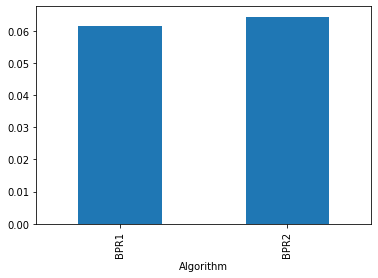

In [ ]:
results.groupby('Algorithm').ndcg.mean().plot.bar()

In [ ]:
df = pd.merge (results_df, user_df, on= "user")
df

,Algorithm,user,nrecs,ndcg,gender,age,occ,zip
0,BPR2,1,10.0,0.046424,F,1,10,48067
1,BPR2,2,10.0,0.211409,M,56,16,70072
2,BPR2,3,10.0,0.239605,M,25,15,55117
3,BPR2,4,10.0,0.000000,M,45,7,02460
4,BPR2,5,10.0,0.000000,M,25,20,55455
...,...,...,...,...,...,...,...,...
6032,BPR2,6036,10.0,0.122878,F,25,15,32603
6033,BPR2,6037,10.0,0.204788,F,45,1,76006
6034,BPR2,6038,10.0,0.000000,F,56,1,14706
6035,BPR2,6039,10.0,0.072552,F,45,0,01060


In [ ]:
# df = df[df['Algorithm'] == 'BPR2']
# df
df["ndcg"].mean()

0.10603605270492161

In [ ]:
df["ndcg"].mean()
df_F = df[df['gender'] == 'F']
df_F["ndcg"].mean()
df_M = df[df['gender'] == 'M']
df_M["ndcg"].mean()

0.08715538216440724

In [ ]:
df_M = df[df['gender'] == 'M']
df_M["ndcg"].mean()

0.11348539095467904